# MAHTS generation

## Background


## Description

* Take full time series of NDWI in dask
* Compute 2D tides for every timestep
* Compute median of tides from entire tide timeseries
* For each year in dask NDWI timeseries:
    * Mask pixels where tide > overall median
    * `.compute()` and take median 
    
***


## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [98]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import otps
import datacube
import shapely.wkt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
# from skimage import measure
from datacube.helpers import write_geotiff
from datacube.virtual import catalog_from_file

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_plotting import display_map
from dea_spatialtools import interpolate_2d



def interpolate_tide(timestep_ds, tidepoints_gdf, method='rbf', factor=20):    
    '''
    Extract a subset of tide modelling point data for a given time-step,
    then interpolate these tides into the extent of the xarray dataset.
    '''    
  
    # Extract subset of observations based on timestamp of imagery
    time_string = str(timestep_ds.time.values)[0:19].replace('T', ' ')
    tidepoints_subset = tidepoints_gdf.loc[time_string]
    print(time_string, end='\r')
    
    # Get lists of x, y and z (tide height) data to interpolate
    x_coords = tidepoints_subset.geometry.x,
    y_coords = tidepoints_subset.geometry.y,
    z_coords = tidepoints_subset.tide_m
    
    # Interpolate tides into the extent of the satellite timestep
    out_tide = interpolate_2d(ds=timestep_ds,
                              x_coords=x_coords,
                              y_coords=y_coords,
                              z_coords=z_coords,
                              method=method,
                              factor=factor)
    
    # Return data as a Float32 to conserve memory
    return out_tide.astype(np.float32)


def tidal_composite(year_ds, tide_cutoff, output_dir, export_geotiff=False):
    '''
    Loads data for a time period into memory, masks to keep only
    pixels observed at > median tide, takes median and counts of valid 
    water index results, and optionally writes each water index, tide 
    height and valid pixel counts for the time period to file
    '''
    
    # Print status
    year = year_ds.time[0].dt.year.item()
    print(f'Processing {year}', end='\r')
    
    # Determine what pixels were acquired above median tide, and drop
    # time-steps without any pixels above median tide to reduce data to load
    high_tide_bool = year_ds.tide_m >= tide_cutoff
    year_ds = year_ds.sel(time=high_tide_bool.sum(dim=['x', 'y']) > 0)
    
    # Apply mask, and load in corresponding high tide data
    year_ds = year_ds.where(high_tide_bool)
    year_ds = year_ds.compute()
    
    # Compute median water indices and counts of valid pixels
    median_ds = year_ds.median(dim='time', keep_attrs=True)
    median_ds['count'] = (year_ds.mndwi
                          .count(dim='time', keep_attrs=True)
                          .astype('int16'))
    median_ds['stdev'] = year_ds.mndwi.std(dim='time', keep_attrs=True)
    
    # Write each variable to file
    geotiff_profile = {'blockxsize': 1024, 
                       'blockysize': 1024, 
                       'compress': 'deflate', 
                       'zlevel': 9}
    
    if export_geotiff:
        for i in median_ds:
            write_geotiff(filename=f'{output_dir}/{i}_{str(year)}.tif', 
                          dataset=median_ds[[i]],
                          profile_override=geotiff_profile)
        
    return median_ds


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up Dask

In [4]:
# from datacube.utils.rio import configure_s3_access
# from datacube.utils.dask import start_local_dask
# import os
# import dask
# from dask.utils import parse_bytes

# # configure dashboard link to go over proxy
# dask.config.set({"distributed.dashboard.link":
#                  os.environ.get('JUPYTERHUB_SERVICE_PREFIX', '/')+"proxy/{port}/status"});

# # Figure out how much memory/cpu we really have (those are set by jupyterhub)
# mem_limit = int(os.environ.get('MEM_LIMIT', '0'))
# cpu_limit = float(os.environ.get('CPU_LIMIT', '0'))
# cpu_limit = int(cpu_limit) if cpu_limit > 0 else 4
# mem_limit = mem_limit if mem_limit > 0 else parse_bytes('8Gb')

# # leave 4Gb for notebook itself
# mem_limit -= parse_bytes('4Gb')

# # close previous client if any, so that one can re-run this cell without issues
# client = locals().get('client', None)
# if client is not None:
#     client.close()
#     del client
    
# client = start_local_dask(n_workers=1,
#                           threads_per_worker=cpu_limit, 
#                           memory_limit=mem_limit)
# display(client)

# # Configure GDAL for s3 access 
# configure_s3_access(aws_unsigned=True,  # works only when reading public resources
#                     client=client);

### Connect to the datacube

In [5]:
dc = datacube.Datacube(app='MAHTS_testing', env='c3-samples')
# dc = datacube.Datacube(app='MAHTS_testing')

### Load virtual products catalogue


In [6]:
catalog = catalog_from_file('MAHTS_virtual_products.yaml')

### Load tidal points


In [7]:
points_gdf = gpd.read_file('input_data/tide_points_coastal.geojson')

In [96]:
# name = 'stradbroke'
# query = {'x': (153.42, 153.61),
#          'y': (-27.35, -28.4919),
#          'time': ('1987', '2018'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80],
#         }


# name = 'goldcoast_test'
# query = {'x': (153.42, 153.61),
#          'y': (-28.0235, -28.4281),
#          'time': ('1987', '2018'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80],
#         }


# # Gold Coast
# name = 'brisbane'
# query = {'x': (153.00, 153.50),
#          'y': (-26.6499,  -27.6495),
#          'time': ('1987', '2018'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80],
#         }


# name = 'fraser'
# query = {'x': (152.9819, 153.20),
#          'y': (-25.60,  -26.67),
#          'time': ('1987', '2018'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80],
#         }


# name = 'yamba'
# query = {'x': (153.29,  153.4735  ),
#          'y': (-29.0994,  -29.7381),
#          'time': ('1987', '2018'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80],
#         }

    
name = 'byron'
query = {'x': (153.42, 153.645),
         'y': (-28.46, -29.17),
         'time': ('1987', '2018'),
         'dask_chunks': {'x': 1000, 'y': 1000},
         'cloud_cover': [0, 80]}


# # Moreton Bay
# name = 'moretonbay'
# query = {'x': (153.00, 153.25),
#          'y': (-26.81, -27.44),
#          'time': ('2008', '2008'),
#          'cloud_cover': [0, 80]}

# # Moreton Bay seam test
# name = 'moretonbay'
# query = {'x': (153.10, 153.18),
#          'y': (-26.70, -26.83),
#          'time': ('2000', '2010'),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}

# # Moreton Bay small
# name = 'moretonbay'
# query = {'x': (153.16, 153.2840),
#          'y': (-27.315, -27.4416),
#          'time': ('2000', '2010'),
# #          'output_crs': 'EPSG:32756',
# #          'resolution': (-30, 30),
#          'dask_chunks': {'time': 1},
#          'cloud_cover': [0, 80]}

name = 'perthsmall'
query = {'x': (115.71,  115.7777),
         'y': (-31.7363, -31.8787),
         'time': ('1987', '2018'),
         'dask_chunks': {'x': 1000, 'y': 1000},
         'cloud_cover': [0, 80]}


name = 'fremantle'
query = {'x': (115.7199,  115.7650),
         'y': (-31.9944, -32.0786),
         'time': ('1987', '2018'),
         'dask_chunks': {'x': 1000, 'y': 1000},
         'cloud_cover': [0, 80]}

name = 'fremantle2'
query = {'x': (115.7312,  115.7726),
         'y': ( -32.0692, -32.1451),
         'time': ('1987', '2018'),
         'dask_chunks': {'x': 1000, 'y': 1000},
         'cloud_cover': [0, 80]}

name = 'portlonsdale'
query = {'x': (144.471801,  144.7868),
         'y': (-38.0816, -38.35),
         'time': ('1987', '2018'),
         'dask_chunks': {'x': 1000, 'y': 1000},
         'cloud_cover': [0, 80]}


name = 'cornerinlet'
query = {'x': (146.4381,  146.93),
         'y': (-38.58, -38.8253),
         'time': ('1987', '2018'),
         'dask_chunks': {'x': 1000, 'y': 1000},
         'cloud_cover': [0, 80]}

name = 'cornerinletsmall'
query = {'x': (146.6431, 146.78),
         'y': (-38.6541, -38.7562),
         'time': ('1987', '2018'),
         'dask_chunks': {'x': 1000, 'y': 1000},
         'cloud_cover': [0, 80]}
    

# Preview study area
display_map(x=query['x'], y=query['y'])

## Load virtual product

In [17]:
# product = catalog['ls_nbart_indices']
# ds = product.load(dc, **query)
# ds

from dea_datahandling import load_ard
from dea_bandindices import calculate_indices

ds = load_ard(dc=dc, 
              measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
              min_gooddata=0.0,
              products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3'], 
              output_crs='epsg:32755',
              resampling={'*': 'average', 'fmask': 'nearest', 'oa_fmask': 'nearest'},
              resolution=(-30, 30),  
              gqa_iterative_mean_xy=[0, 1],
              align=(15, 15),
              lazy_load=True,
              group_by='solar_day',
              **query)

ds = (calculate_indices(ds, index=['NDWI', 'MNDWI', 'AWEI_ns', 'AWEI_sh'], 
                        collection='ga_ls_3', 
                        drop=True)
      .rename({'NDWI': 'ndwi', 'MNDWI': 'mndwi', 'AWEI_ns': 'awei_ns', 'AWEI_sh': 'awei_sh'}))

Loading ga_ls5t_ard_3 data
    462 observations
    Applying pixel quality mask
Loading ga_ls7e_ard_3 data
    538 observations
    Applying pixel quality mask
Loading ga_ls8c_ard_3 data
    176 observations
    Applying pixel quality mask
Combining and sorting data
Masking out invalid values
    Returning 1176 observations as a dask array
Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


## Model tides

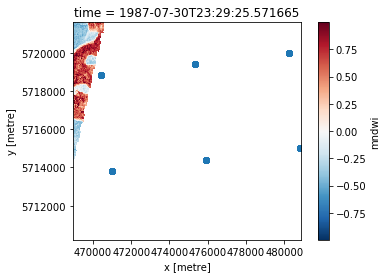

In [18]:
# Pull out subset of modelling points for region around satellite data
bounds = shapely.wkt.loads(ds.geobox.geographic_extent.buffer(0.07).wkt)
subset_gdf = points_gdf[points_gdf.geometry.intersects(bounds)]

# Extract lon, lat from tides, and time from satellite data
x_vals = subset_gdf.geometry.centroid.x
y_vals = subset_gdf.geometry.centroid.y
observed_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()

# Create list of lat/lon/time scenarios to model
observed_timepoints = [otps.TimePoint(lon, lat, date) 
                       for date in observed_datetimes
                       for lon, lat in zip(x_vals, y_vals)]

# Model tides for each scenario
observed_predictedtides = otps.predict_tide(observed_timepoints)

# Output results into pandas.DataFrame
tidepoints_df = pd.DataFrame([(i.timepoint.timestamp, 
                               i.timepoint.lon, 
                               i.timepoint.lat, 
                               i.tide_m) for i in observed_predictedtides], 
                             columns=['time', 'lon', 'lat', 'tide_m']) 

# Convert data to spatial geopandas.GeoDataFrame
tidepoints_gdf = gpd.GeoDataFrame(data={'time': tidepoints_df.time, 
                                        'tide_m': tidepoints_df.tide_m}, 
                                  geometry=gpd.points_from_xy(tidepoints_df.lon, 
                                                              tidepoints_df.lat), 
                                  crs={'init': 'EPSG:4326'})

# Reproject to satellite data CRS
tidepoints_gdf = tidepoints_gdf.to_crs(epsg=ds.crs.epsg)

# Fix time and set to index
tidepoints_gdf['time'] = pd.to_datetime(tidepoints_gdf['time'], utc=True)
tidepoints_gdf = tidepoints_gdf.set_index('time')

# Plot a sample timestep
ds.isel(time=0).mndwi.plot()
tidepoints_gdf.plot(ax=plt.gca())

### Interpolate tides into each satellite timestep

In [19]:
# Interpolate tides for each timestep into the spatial extent of the data
tide_da = ds.groupby('time').apply(interpolate_tide, 
                                   tidepoints_gdf=tidepoints_gdf,
                                   factor=53)

# Determine tide cutoff
tide_cutoff = tide_da.median(dim='time')

# Add interpolated tides as measurement in satellite dataset
ds['tide_m'] = tide_da

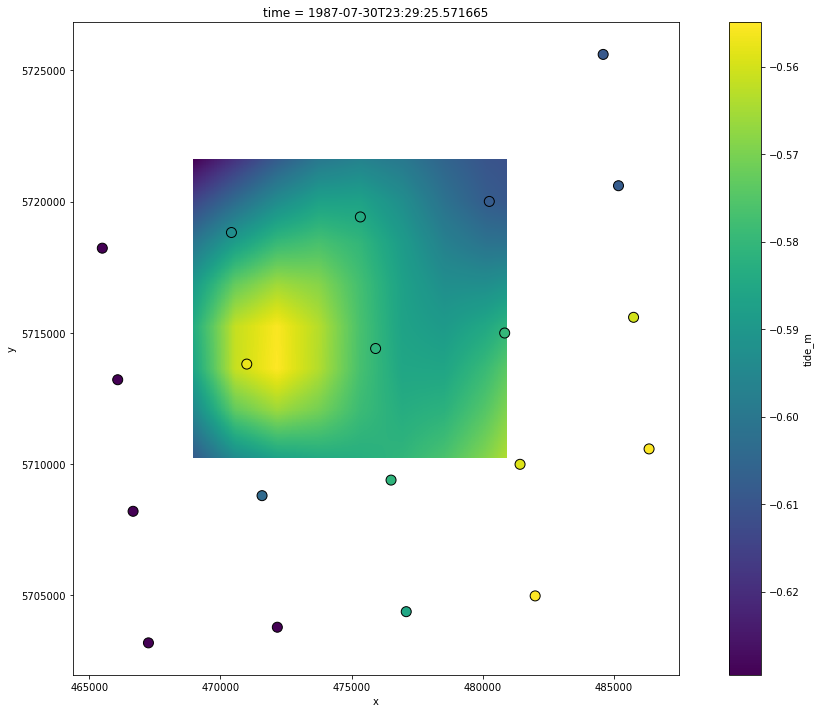

In [20]:
# Plot 
ds_i = ds['tide_m'].isel(time=0)
ds_i.plot.imshow(robust=True, 
                 cmap='viridis', 
                 size=12, 
                 vmin=ds_i.min().item(), 
                 vmax=ds_i.max().item())
tidepoints_gdf.loc[str(ds_i.time.values)[0:10]].plot(ax=plt.gca(), 
                                                     column='tide_m', 
                                                     cmap='viridis', 
                                                     markersize=100,
                                                     edgecolor='black',
                                                     vmin=ds_i.min().item(), 
                                                     vmax=ds_i.max().item())

## Generate yearly composites

In [97]:
# If output folder doesn't exist, create it
output_dir = f'output_data/{name}'
os.makedirs(output_dir, exist_ok=True)

# Generate yearly high tide median water indices
yearly_ds = ds.groupby('time.year').apply(tidal_composite, 
                                          tide_cutoff=tide_cutoff, 
                                          output_dir=output_dir,
                                          export_geotiff=True)


Processing 1987
Processing 1988
Processing 1989
Processing 1990
Processing 1991
Processing 1992
Processing 1993
Processing 1994
Processing 1995
Processing 1996
Processing 1997
Processing 1998
Processing 1999
Processing 2000
Processing 2001
Processing 2002
Processing 2003
Processing 2004
Processing 2005
Processing 2006
Processing 2007
Processing 2008
Processing 2009
Processing 2010
Processing 2011
Processing 2012
Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018


In [99]:
ds.rolling()

<xarray.Dataset>
Dimensions:  (x: 398, y: 379, year: 32)
Coordinates:
  * x        (x) float64 4.69e+05 4.69e+05 4.69e+05 ... 4.808e+05 4.809e+05
  * y        (y) float64 5.722e+06 5.722e+06 5.722e+06 ... 5.71e+06 5.71e+06
  * year     (year) int64 1987 1988 1989 1990 1991 ... 2014 2015 2016 2017 2018
Data variables:
    ndwi     (year, y, x) float32 -0.5587997 -0.56967217 ... 0.4535401
    mndwi    (year, y, x) float32 -0.5340471 -0.55677503 ... 0.4693362 0.5428828
    awei_ns  (year, y, x) float32 -0.51206666 -0.5409895 ... 0.05373163
    awei_sh  (year, y, x) float32 -0.40825003 -0.42112496 ... 0.0654625
    tide_m   (year, y, x) float32 0.36667258 0.36643207 ... 0.33676147 0.3367254
    count    (year, y, x) int16 3 3 3 3 3 3 3 3 3 ... 10 10 10 10 10 11 11 10 10
    stdev    (year, y, x) float32 0.10806141 0.086184934 ... 0.28364474
Attributes:
    crs:      epsg:32755

In [ ]:
# Plot
yearly_ds['count'].sum(dim='year').plot(size=10, robust=True)

In [ ]:
yearly_ds.geobox.transform

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)